# Supplement - linear and nonlinear centerline pressure
This notebook generates Figure 1 in the supplementary material. This figure shows the variation in outlet pressure decomposed into the linear and nonlinear component for varying downstream distances, $x/D$ and pressure drops immediately behind the rotor, $\Delta p$.

In [1]:
from pathlib import Path
import os

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from UnifiedMomentumModel.Momentum import UnifiedMomentum
from UnifiedMomentumModel.Pressure.PressureTable import generate_pressure_table

np.seterr(all="ignore")

figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)
figdir_eps = figdir / "eps"
figdir_eps.mkdir(exist_ok=True, parents=True)

# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

# Define discretisation
ddp = 0.1
dx = 0.2
dps = np.arange(0, 1 + ddp, ddp)
xs = np.arange(0, 10, dx)

dp_mesh, x_mesh = np.meshgrid(dps, xs, indexing="ij")

# Linear pressure solution, $p^{L}$

In [2]:
p_linear = -(1 / (2 * np.pi)) * dp_mesh * np.arctan(1 / (2 * x_mesh))

## Nonlinear pressure solution, $p^{NL}$

In [3]:
dps2, xs2, p_nonlinear = generate_pressure_table(ddp)

# Save data to file

In [11]:
SOURCEDATADIR = Path(os.getcwd()).parent / "source_data/Figure_supp_01"
SOURCEDATADIR.mkdir(exist_ok=True, parents=True)

df_linear = pl.DataFrame({"x": x_mesh.ravel(), "dp": dp_mesh.ravel(), "p": p_linear.ravel()}).select(pl.lit("linear").alias("component"), "x", "dp", "p")

xmesh2, dpmesh2 = np.meshgrid(xs2, dps2)
df_nonlinear = pl.DataFrame({"x": xmesh2.ravel(), "dp": dpmesh2.ravel(), "p": p_nonlinear.ravel()}).select(pl.lit("nonlinear").alias("component"), "x", "dp", "p")

df = pl.concat([df_linear, df_nonlinear])
df.write_csv(SOURCEDATADIR / "figure_supp_01_contour_data.csv")

## Plot

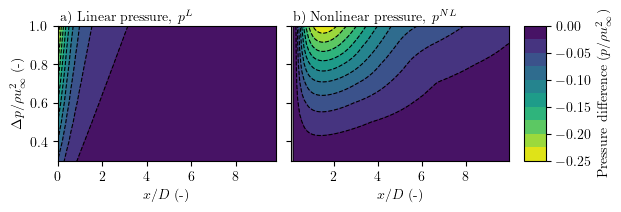

In [4]:
# Set up axes
fig = plt.figure(figsize=0.7 * np.array((9, 2.5)))
gs = GridSpec(1, 3, width_ratios=[1, 1, 0.1], wspace=0.1)

axes = [plt.subplot(gs[0])]
axes.append(plt.subplot(gs[1], sharey=axes[0]))
plt.setp(axes[1].get_yticklabels(), visible=False)


labels = {
    "linear": "a) Linear pressure, $p^L$",
    "nonlinear": r"b) Nonlinear pressure, $p^{NL}$",
}
contourf_kwargs = {
    "linear": dict(cmap="viridis_r"),
    "nonlinear": dict(cmap="viridis_r"),
}

# Text/titles
for key, ax in zip(["linear", "nonlinear"], axes):
    ax.text(
        0.01,
        1 + 0.01,
        labels[key],
        ha="left",
        va="bottom",
        transform=ax.transAxes,
    )
levels = np.arange(-0.25, 0.001, 0.025)

# axes 1: Linear
CF = axes[0].contourf(xs, dps, p_linear, levels=levels, cmap="viridis_r")
CS = axes[0].contour(xs, dps, p_linear, levels=levels, colors="k", linewidths=0.8)

axes[0].set_ylim(0.3, 1)

# axes 2: Nonlinear
CF = axes[1].contourf(xs2, dps2, p_nonlinear, levels=levels, cmap="viridis_r")
CS = axes[1].contour(xs2, dps2, p_nonlinear, levels=levels, colors="k", linewidths=0.8)

axes[1].set_ylim(0.3, 1)


axes[0].set_xlabel("$x/D$ (-)")
axes[1].set_xlabel("$x/D$ (-)")
axes[0].set_ylabel(r"$\Delta p /\rho u_\infty^2$ (-)")

cax = plt.subplot(gs[2])
cbar = plt.colorbar(CF, cax=cax)
cbar.set_label(label=r"Pressure difference $(p/\rho u_\infty^2)$")


plt.savefig(figdir / "supplement_centerline_pressure.png", dpi=500, bbox_inches="tight")
plt.savefig(figdir_eps / "supplement_centerline_pressure.eps", bbox_inches="tight")